In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
plt.style.use("ggplot")

In [2]:
with open("NKJP_org.csv") as f:
    text= f.read()
sentences = text.split("\n\n")
split_sentences = [sentence.split("\n") for sentence in sentences if any(sentence)]

In [3]:
grouped_sentences = []
for sentence in split_sentences:
    s = []
    for word in sentence:
        s.append(word.split("\t"))
    grouped_sentences.append(s)
    
for sentence in grouped_sentences:
    for word in sentence:
        if len(word) == 2:
            word.extend(["O", "O"])
        if len(word) == 3:
            word.insert(2, 'O')

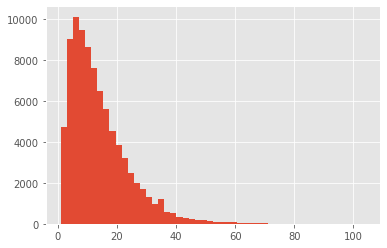

In [4]:
%matplotlib inline
plt.hist([len(sen) for sen in grouped_sentences], bins= 50)
plt.show()

In [5]:
biggest_len = max([len(s) for s in grouped_sentences])
biggest_len

104

In [6]:
max_len = 55

In [7]:
data = []
all_labels = []
all_tokens = ['<PAD>']
for sentences in grouped_sentences:
    if len(sentences) <= max_len:
        tokens = [sentence[0] for sentence in sentences]
        labels = [sentence[3] for sentence in sentences]
        assert len(tokens) <= max_len
        pads_number_to_extend = max_len-len(tokens)
        tokens.extend(['<PAD>'] * pads_number_to_extend)
        labels.extend(['O'] * pads_number_to_extend)
        assert len(tokens) == max_len
        assert len(labels) == max_len
        data.append({'tokens': tokens, "labels": labels})
        all_tokens.extend(tokens)
        all_labels.extend(labels)

In [8]:
tokens_number = len(set(all_tokens))
labels_number = len(set(all_labels))
tokens_number, labels_number

(140583, 15)

In [9]:
set(all_labels)

{'O',
 'addName',
 'bloc',
 'country',
 'date',
 'district',
 'forename',
 'geogName',
 'orgName',
 'persName',
 'placeName',
 'region',
 'settlement',
 'surname',
 'time'}

In [10]:
words2index = {w:i for i,w in enumerate(list(set(all_tokens)))}
tags2index = {t:i for i,t in enumerate(list(set(all_labels)))}
index2words = {i:w for i,w in enumerate(list(set(all_tokens)))}
index2tags = {i:t for i,t in enumerate(list(set(all_labels)))}

In [11]:
print(words2index['Liceum'])
print(tags2index['geogName'])

3007
9


In [12]:
data[0]

{'tokens': ['Bohaterem',
  'powieści',
  'Paźniewskiego',
  'jest',
  'miasto',
  ',',
  'Krzemieniec',
  '.',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>'],
 'labels': ['O',
  'O',
  'surname',
  'O',
  'O',
  'O',
  'settlement',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '

In [13]:
x = [[words2index[w] for w in sentence['tokens']] for sentence in data]
y = [[tags2index[w] for w in sentence['labels']] for sentence in data]

In [14]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_tr, X_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=1)

In [15]:
!pip install tensorflow_hub

In [16]:
batch_size = 64
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
sess = tf.Session()
K.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
import keras
from keras.models import Model
from tensorflow.keras.layers import Input, add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [18]:
X_tr, X_val = np.array(X_tr[:1213*batch_size]), np.array(X_tr[-135*batch_size:])
y_tr, y_val = np.array(y_tr[:1213*batch_size]), np.array(np.array(y_tr[-135*batch_size:]))

In [19]:
X_te = np.array(X_te)

In [20]:
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [21]:
y_te = np.array(y_te)
y_te = y_te.reshape(y_te.shape[0], y_te.shape[1], 1)

In [22]:
X_tr.shape

(68172, 55)

In [23]:
assert len(X_tr) == len(y_tr)
assert len(X_val) == len(y_val)

In [24]:
input_text = Input(shape=(55,))
embedding = Embedding(
        input_dim=tokens_number+1,
        input_length=max_len,
        output_dim=20,
        mask_zero=True
       )(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
_x = add([x, x_rnn])
out = TimeDistributed(Dense(labels_number, activation="softmax"))(_x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
model = Model(input_text, out)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [26]:
history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 68172 samples, validate on 34560 samples
Epoch 1/3
68172/68172 [==============================] - ETA: 0s - loss: 0.2405 - acc: 0.9826

/home/kuba/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


68172/68172 [==============================] - 402s 6ms/sample - loss: 0.2405 - acc: 0.9826 - val_loss: 0.2258 - val_acc: 0.9860
Epoch 2/3
68172/68172 [==============================] - 396s 6ms/sample - loss: 0.2249 - acc: 0.9860 - val_loss: 0.2258 - val_acc: 0.9860
Epoch 3/3
68172/68172 [==============================] - 396s 6ms/sample - loss: 0.2249 - acc: 0.9860 - val_loss: 0.2258 - val_acc: 0.9860


In [27]:
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

/home/kuba/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [28]:
loss, accuracy = model.evaluate(X_te, y_te, batch_size=256)
print(f"Test loss: {loss}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Test loss: 0.22584213756314678
Test accuracy: 98.6%


In [24]:
input_text_2 = Input(shape=(55,))
embedding_2 = Embedding(
        input_dim=tokens_number+1,
        input_length=max_len,
        output_dim=20,
        mask_zero=True
       )(input_text_2)
x_1 = Bidirectional(LSTM(units=256, return_sequences=True,
                       recurrent_dropout=0.4, dropout=0.4))(embedding_2)
x_rnn_1 = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.4, dropout=0.4))(x_1)
_x_1 = add([x_1, x_rnn_1])
x_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(_x_1)
x_rnn_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x_2)
_x_2 = add([x_2, x_rnn_2])

out_2 = TimeDistributed(Dense(labels_number, activation="softmax"))(_x_2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
model_2 = Model(input_text_2, out_2)
model_2.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [26]:
history_2 = model_2.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 68172 samples, validate on 8640 samples
Epoch 1/3
68172/68172 [==============================] - ETA: 0s - loss: 0.2277 - acc: 0.9852

/home/kuba/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


68172/68172 [==============================] - 1572s 23ms/sample - loss: 0.2277 - acc: 0.9852 - val_loss: 0.2265 - val_acc: 0.9859
Epoch 2/3
68172/68172 [==============================] - 1564s 23ms/sample - loss: 0.2249 - acc: 0.9860 - val_loss: 0.2265 - val_acc: 0.9859
Epoch 3/3
68172/68172 [==============================] - 1580s 23ms/sample - loss: 0.2249 - acc: 0.9860 - val_loss: 0.2265 - val_acc: 0.9859


In [29]:
loss, accuracy = model_2.evaluate(X_te, y_te, batch_size=64)
print(f"Test loss: {loss}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Test loss: 0.22584216072058122
Test accuracy: 98.6%


In [30]:
y_pred = model_2.predict(X_te, batch_size=64, verbose=1)
y_true_bool = np.argmax(y_te, axis=1)

/home/kuba/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [31]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
f1_m(y_te, y_pred.astype('float64'))

0.933756

do wytrenowania modelu NER wykorzystano dane z kanału teams. Składało się na nie 140583 słów i 15 etykiet. Przed podaniem ich do modelu w pierwszej kolejności zamieniono słowa na wartości numeryczne, używając najprostszej metody- worka słów. potem wyrównano wszystkie zdania do równej długości wstawiając w te któtsze frazę '<PAD>' i odpowiadającą jej pustą etykietę 'O'. Architektura modelu sieci neuronowej oparta jest na warstwach dwukierunkowych LSTM- które uczą się, co przechowywać w staniedługoterminowym, co wyrzucić i co z niego czytać. By zapobiec przetrenowaniu się sieci zastosowano parametr dropout, który losowo usuwał 20% połączeń podczas treningu. Poskutkowało to zadowalającym wynikiem powyżej 98,5% accuracy zarówno na zbiorze walidacyjnym jak i testowym. Dodanie większej ilości warstw LSTM nie poprawiło rezultatu.